# Init

In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/wliao0504/code/clif/CLIF-epi-of-sedation'

## Import

In [2]:
from clifpy import ClifOrchestrator
import pandas as pd
import duckdb
from pathlib import Path
from clifpy.utils.unit_converter import convert_dose_units_by_med_category

In [3]:
site = 'mimic'

In [4]:
q = """
SET TimeZone='US/Eastern'
"""
duckdb.sql(q)

## Utils

In [5]:
def run_query_from_file(sql_file_path: str) -> duckdb.DuckDBPyRelation:
    """
    Loads a query from a .sql file and executes it using the given DuckDB connection.

    Args:
        con: An active DuckDB connection.
        sql_file_path: The absolute path to the .sql file.

    Returns:
        A pandas DataFrame with the results of the query.
    """
    print(f"--- Loading and executing query from {sql_file_path} ---")
    
    # Read the entire content of the .sql file
    query = Path(sql_file_path).read_text()

    # Execute the query and return as a pandas DataFrame
    result = duckdb.sql(query)

    print("Query executed successfully.")
    return result

In [6]:
def add_day_shift_id(df: pd.DataFrame, timestamp_name = 'event_dttm') -> pd.DataFrame:
    df['_dh'] = df[timestamp_name].dt.floor('h')
    df['_hr'] = df[timestamp_name].dt.hour
    q = """
    WITH day_starts AS (
        FROM df
        SELECT *
            , _shift: CASE WHEN _hr >= 7 AND _hr < 19 THEN 'day' ELSE 'night' END
            , _is_day_start: CASE
                WHEN _hr = 7 AND COALESCE(LAG(_hr) OVER w, -1) != 7 THEN 1
                ELSE 0 END
        WINDOW w AS (PARTITION BY hospitalization_id ORDER BY _dh)       
    )
    FROM day_starts
    -- INNER JOIN cohort_hosp_ids_df USING (hospitalization_id)
    SELECT *
        , _nth_day: SUM(_is_day_start) OVER w
        , _day_shift: 'day' || _nth_day::INT::TEXT || '_' || _shift
    WINDOW w AS (PARTITION BY hospitalization_id ORDER BY _dh)       
    ORDER BY hospitalization_id, _dh
    """
    return duckdb.sql(q).df()

# Cohort ID

In [7]:
from clifpy import Adt, Hospitalization

adt = Adt.from_file(
    config_path = 'config/config.json',
    columns = ['hospitalization_id', 'in_dttm', 'out_dttm', 'location_category'],
    filters = {
        'location_category': ['icu']
    }
    )

hosp_ids_w_icu_stays = adt.df['hospitalization_id'].unique().tolist()

📢 Initialized adt table
📢 Data directory: /Users/wliao0504/code/clif/CLIF-MIMIC/output/rclif-dev-test
📢 File type: parquet
📢 Timezone: US/Eastern
📢 Output directory: /Users/wliao0504/code/clif/CLIF-epi-of-sedation/output
📢 Loaded schema from /Users/wliao0504/code/clif/CLIF-epi-of-sedation/.venv/lib/python3.12/site-packages/clifpy/schemas/adt_schema.yaml
📢 Loaded outlier configuration


In [8]:
from clifpy.utils.stitching_encounters import stitch_encounters

# Load your dataframes
hosp_w_icu_stays = Hospitalization.from_file(
    config_path = 'config/config.json',
    filters = {
        'hospitalization_id': hosp_ids_w_icu_stays
    }
)
adt_w_icu_stays = Adt.from_file(
    config_path = 'config/config.json',
    filters = {
        'hospitalization_id': hosp_ids_w_icu_stays
    }
    # columns = ['hospitalization_id', 'in_dttm', 'out_dttm', 'location_category'],
    )

# Perform stitching
hosp_stitched, adt_stitched, encounter_mapping = stitch_encounters(
    hospitalization=hosp_w_icu_stays.df,
    adt=adt_w_icu_stays.df,
    time_interval=12  # 12-hour window
)

📢 Configuration loaded from config/config.json
📢 Initialized hospitalization table
📢 Data directory: /Users/wliao0504/code/clif/CLIF-MIMIC/output/rclif-dev-test
📢 File type: parquet
📢 Timezone: US/Eastern
📢 Output directory: /Users/wliao0504/code/clif/CLIF-epi-of-sedation/output
📢 Loaded schema from /Users/wliao0504/code/clif/CLIF-epi-of-sedation/.venv/lib/python3.12/site-packages/clifpy/schemas/hospitalization_schema.yaml
📢 Loaded outlier configuration
📢 Configuration loaded from config/config.json
📢 Initialized adt table
📢 Data directory: /Users/wliao0504/code/clif/CLIF-MIMIC/output/rclif-dev-test
📢 File type: parquet
📢 Timezone: US/Eastern
📢 Output directory: /Users/wliao0504/code/clif/CLIF-epi-of-sedation/output
📢 Loaded schema from /Users/wliao0504/code/clif/CLIF-epi-of-sedation/.venv/lib/python3.12/site-packages/clifpy/schemas/adt_schema.yaml
📢 Loaded outlier configuration


In [9]:
# processed_bf = co.respiratory_support.waterfall(bfill = True)
# processed_bf.df.to_parquet(f"output/intermediate/{site}_resp_processed_bf.parquet")

# resp_p = processed_bf.df
resp_p = pd.read_parquet(f"output/intermediate/{site}_resp_processed_bf.parquet")

resp_p['tracheostomy'] = resp_p['tracheostomy'].astype(int)

## Time grids

In [25]:
all_streaks = run_query_from_file('code/cohort_id.sql').df()

--- Loading and executing query from code/cohort_id.sql ---
Query executed successfully.


In [33]:
# build the observation-window hourly time grids
# start and end time for each hospitalization_id is the start and end of the first IMV streak of 24 hours or longer
# the end of the imv streak means extubation, which we evaulates whether as successful or not

q = """
FROM all_streaks
SELECT hospitalization_id, _streak_id, _start_dttm, _end_dttm, _duration_hrs
WHERE _at_least_24h = 1 -- has to last for at least 24 hours
    AND _on_imv = 1 -- has to be an IMV streak
    AND _streak_id = 1 -- has to bethe first IMV streak
"""
cohort_imv_streaks_f = duckdb.sql(q).df()

In [46]:
cohort_hosp_ids = cohort_imv_streaks_f['hospitalization_id'].unique().tolist()

In [37]:
cohort_imv_streaks_f['_start_hr'] = cohort_imv_streaks_f['_start_dttm'].dt.floor('h')
cohort_imv_streaks_f['_end_hr'] = cohort_imv_streaks_f['_end_dttm'].dt.ceil('h')

q = """
SELECT 
    hospitalization_id,
    unnest(generate_series(_start_hr, _end_hr, INTERVAL '1 hour')) AS event_dttm
FROM cohort_imv_streaks_f
ORDER BY hospitalization_id, event_dttm
"""
cohort_hrly_grids = duckdb.sql(q).df()

#shift_change_grids = hrly_grids[hrly_grids['_hr'].isin([7, 19])]

In [38]:
cohort_hrly_grids_f = add_day_shift_id(cohort_hrly_grids)
assert len(cohort_hrly_grids_f) == len(cohort_hrly_grids), 'length altered'

In [40]:
shift_change_grids = cohort_hrly_grids_f[cohort_hrly_grids_f['_hr'].isin([7, 19])]

## Exclude: neuromuscular blocking agent

In [15]:
from clifpy import MedicationAdminContinuous

# neuromuscular blocking agent
nmb = MedicationAdminContinuous.from_file(
    config_path = 'config/config.json',
    columns = ['hospitalization_id', 'admin_dttm', 'med_name', 'med_category', 'med_dose', 'med_dose_unit'],
    filters = {
        'med_category': ['cisatracurium', 'vecuronium', 'rocuronium']
    }
)

nmb_df = nmb.df

📢 Configuration loaded from config/config.json
📢 Initialized medication_admin_continuous table
📢 Data directory: /Users/wliao0504/code/clif/CLIF-MIMIC/output/rclif-dev-test
📢 File type: parquet
📢 Timezone: US/Eastern
📢 Output directory: /Users/wliao0504/code/clif/CLIF-epi-of-sedation/output
📢 Loaded schema from /Users/wliao0504/code/clif/CLIF-epi-of-sedation/.venv/lib/python3.12/site-packages/clifpy/schemas/medication_admin_continuous_schema.yaml
📢 Loaded outlier configuration


In [ ]:
# q = """
# -- converting to wide format
# WITH t1 AS (
#     SELECT hospitalization_id
#         , admin_dttm as event_dttm
#         , med_category_unit: med_category || '_' || REPLACE(med_dose_unit_converted, '/', '_') || '_cont'
#         , med_dose_converted
#     FROM cont_sed_converted
# )
# , t2 AS (
#     PIVOT_WIDER t1
#     ON med_category_unit
#     USING FIRST(med_dose_converted)
# )
# SELECT *
# FROM t2
# ORDER BY hospitalization_id, event_dttm
# """
# cont_sed_w = duckdb.sql(q).df()

# Preprocess

In [52]:
co = ClifOrchestrator(config_path="config/mimic_config.json")

📢 Configuration loaded from config/mimic_config.json
📢 ClifOrchestrator initialized


In [ ]:
#cohort_hosp_ids_df = pd.read_csv('data/cohort_hosp_ids.csv')
# cohort_hosp_ids = cohort_hosp_ids_df['hospitalization_id'].astype(str).tolist()

## Patient & Hosp

In [48]:
from clifpy import Patient, Hospitalization
pt = Patient.from_file(
    config_path = 'config/config.json',
    columns = ['patient_id', 'death_dttm'],
    )
pt_df = pt.df

hosp = Hospitalization.from_file(
    config_path = 'config/config.json',
    columns = ['patient_id', 'hospitalization_id', 'discharge_dttm', 'discharge_category'],
    )
hosp_df = hosp.df

q = """
FROM hosp_df
INNER JOIN cohort_imv_streaks_f USING (hospitalization_id)
SELECT DISTINCT patient_id, hospitalization_id
"""
pt_to_hosp_id_mapper = duckdb.sql(q).df()

cohort_pt_ids = pt_to_hosp_id_mapper['patient_id'].tolist()

📢 Configuration loaded from config/config.json
📢 Initialized patient table
📢 Data directory: /Users/wliao0504/code/clif/CLIF-MIMIC/output/rclif-dev-test
📢 File type: parquet
📢 Timezone: US/Eastern
📢 Output directory: /Users/wliao0504/code/clif/CLIF-epi-of-sedation/output
📢 Loaded schema from /Users/wliao0504/code/clif/CLIF-epi-of-sedation/.venv/lib/python3.12/site-packages/clifpy/schemas/patient_schema.yaml
📢 Loaded outlier configuration
📢 Configuration loaded from config/config.json
📢 Initialized hospitalization table
📢 Data directory: /Users/wliao0504/code/clif/CLIF-MIMIC/output/rclif-dev-test
📢 File type: parquet
📢 Timezone: US/Eastern
📢 Output directory: /Users/wliao0504/code/clif/CLIF-epi-of-sedation/output
📢 Loaded schema from /Users/wliao0504/code/clif/CLIF-epi-of-sedation/.venv/lib/python3.12/site-packages/clifpy/schemas/hospitalization_schema.yaml
📢 Loaded outlier configuration


## Labs

In [56]:
from clifpy import Labs
labs = Labs.from_file(
    config_path = 'config/config.json',
    columns = ['hospitalization_id', 'lab_order_dttm', 'lab_result_dttm', 'lab_category', 'lab_value_numeric'],
    filters = {
        'hospitalization_id': cohort_hosp_ids,
        'lab_category': ['ph_arterial', 'ph_venous']
    }
    )
labs_df = labs.df

📢 Configuration loaded from config/config.json
📢 Initialized labs table
📢 Data directory: /Users/wliao0504/code/clif/CLIF-MIMIC/output/rclif-dev-test
📢 File type: parquet
📢 Timezone: US/Eastern
📢 Output directory: /Users/wliao0504/code/clif/CLIF-epi-of-sedation/output
📢 Loaded schema from /Users/wliao0504/code/clif/CLIF-epi-of-sedation/.venv/lib/python3.12/site-packages/clifpy/schemas/labs_schema.yaml
📢 Loaded outlier configuration


In [57]:
q = """
PIVOT_WIDER labs_df
ON lab_category
USING MAX(lab_value_numeric)
"""
labs_w = duckdb.sql(q).df()
labs_w.head()

,hospitalization_id,lab_order_dttm,lab_result_dttm,ph_arterial,ph_venous
0,28355527,2161-01-18 08:46:00-05:00,2161-01-18 08:50:00-05:00,7.39,NaN
1,26503809,2162-10-06 02:34:00-05:00,2162-10-06 02:37:00-05:00,7.20,7.20
2,21372167,2187-07-21 05:25:00-05:00,2187-07-21 05:29:00-05:00,7.29,7.29
3,27416514,2116-05-08 02:08:00-05:00,2116-05-08 02:24:00-05:00,7.40,7.40
4,25704038,2184-10-08 03:08:00-05:00,2184-10-08 03:12:00-05:00,7.40,7.40


## Vitals

In [58]:
vitals_path = co.data_directory + '/clif_vitals.parquet'
q = f"""
-- find the latest recorded vital for each hospitalization
FROM '{vitals_path}'
SELECT hospitalization_id
    , MAX(recorded_dttm) AS recorded_dttm
GROUP BY hospitalization_id
"""
last_vitals_df = duckdb.sql(q).df()

In [59]:
vitals = co.load_table(
    'vitals', 
    columns = ['hospitalization_id', 'recorded_dttm', 'vital_category', 'vital_value'],
    filters = {
        'vital_category': [
            'spo2', 'weight_kg' # , 'respiratory_rate', 'heart_rate'
            ],
        'hospitalization_id': cohort_hosp_ids
    }
    )
vitals_df = vitals.df

📢 Initialized vitals table
📢 Data directory: /Users/wliao0504/code/clif/CLIF-MIMIC/output/rclif-dev-test
📢 File type: parquet
📢 Timezone: US/Eastern
📢 Output directory: /Users/wliao0504/code/clif/CLIF-epi-of-sedation/output
📢 Loaded schema from /Users/wliao0504/code/clif/CLIF-epi-of-sedation/.venv/lib/python3.12/site-packages/clifpy/schemas/vitals_schema.yaml
📢 Loaded outlier configuration


In [60]:
# q = """
# WITH w AS (
# PIVOT_WIDER vitals_df
# ON vital_category
# USING MAX(vital_value)
# )
# SELECT *
#     , _tachy: CASE WHEN heart_rate > 130 THEN 1 ELSE 0 END
#     , _brady: CASE WHEN heart_rate < 60 THEN 1 ELSE 0 END
#     , _rr_high: CASE WHEN respiratory_rate > 35 THEN 1 ELSE 0 END
#     , _rr_low: CASE WHEN respiratory_rate < 8 THEN 1 ELSE 0 END
# FROM w
# ORDER BY hospitalization_id, recorded_dttm
# """
# vitals_w = duckdb.sql(q).df()
# vitals_w.head()

## Code status

In [61]:
from clifpy import CodeStatus
cs = CodeStatus.from_file(
    config_path = 'config/config.json',
    columns = ['patient_id', 'start_dttm', 'code_status_category'],
    filters = {
        'patient_id': cohort_pt_ids
    }
    )
cs_df = cs.df
q = """
FROM cs_df
LEFT JOIN pt_to_hosp_id_mapper USING (patient_id)
SELECT hospitalization_id, start_dttm, code_status_category
"""
cs_df = duckdb.sql(q).df()

📢 Configuration loaded from config/config.json
📢 Initialized code_status table
📢 Data directory: /Users/wliao0504/code/clif/CLIF-MIMIC/output/rclif-dev-test
📢 File type: parquet
📢 Timezone: US/Eastern
📢 Output directory: /Users/wliao0504/code/clif/CLIF-epi-of-sedation/output
📢 Loaded schema from /Users/wliao0504/code/clif/CLIF-epi-of-sedation/.venv/lib/python3.12/site-packages/clifpy/schemas/code_status_schema.yaml
📢 Loaded outlier configuration


## Resp

In [67]:
sbt_outcomes = run_query_from_file('code/sbt.sql').df()
# assert len(sbt_outcomes_f) == len(resp_p), 'length altered'

--- Loading and executing query from code/sbt.sql ---
Query executed successfully.


In [72]:
## QA
q = """
-- look for represenative examples to eyeball
FROM sbt_outcomes_f
SELECT hospitalization_id
    , MAX(_trach_1st) AS _trach_1st
    , MAX(_fail_extub) AS _fail_extub
    , COUNT(*) AS _n
GROUP BY hospitalization_id
HAVING _trach_1st = 1 AND _fail_extub = 1 AND _N > 100
ORDER BY _n
LIMIT 10
"""
duckdb.sql(q).df()

CatalogException: Catalog Error: Table with name sbt_outcomes_f does not exist!
Did you mean "sqlite_temp_schema"?

In [69]:
sbt_outcomes['_dh'] = sbt_outcomes['event_dttm'].dt.floor('h')
q = """
FROM sbt_outcomes
SELECT hospitalization_id, _dh
    -- , _nth_day
    , sbt_done: COALESCE(MAX(sbt_done), 0)
    -- , _extub_1st: COALESCE(MAX(_extub_1st), 0)
    , success_extub: COALESCE(MAX(_success_extub), 0)
GROUP BY hospitalization_id, _dh
ORDER BY hospitalization_id, _dh
"""
sbt_outcomes_hrly = duckdb.sql(q).df()

In [71]:
q = """
FROM cohort_hrly_grids_f
LEFT JOIN sbt_outcomes_hrly USING (hospitalization_id, _dh)
SELECT *
ORDER BY hospitalization_id, _dh
"""
cohort_sbt_outcomes_hrly = duckdb.sql(q).df()

In [75]:
q = """
FROM cohort_sbt_outcomes_hrly
SELECT hospitalization_id, _nth_day
    , sbt_done: COALESCE(MAX(sbt_done), 0)
    , success_extub: COALESCE(MAX(success_extub), 0)
GROUP BY hospitalization_id, _nth_day
ORDER BY hospitalization_id, _nth_day
"""
cohort_sbt_outcomes_daily = duckdb.sql(q).df()

In [80]:
q = """
FROM cohort_sbt_outcomes_daily
SELECT
    hospitalization_id
    , sbt_done: COALESCE(MAX(sbt_done), 0)
    , success_extub: COALESCE(MAX(success_extub), 0)
GROUP BY hospitalization_id
"""
cohort_sbt_outcomes_by_pt = duckdb.sql(q).df()
print(f"success_extub rate: {cohort_sbt_outcomes_by_pt['success_extub'].mean()}")
print(f"sbt_done rate per day: {cohort_sbt_outcomes_daily['sbt_done'].mean()}")

success_extub rate: 0.6158275143942178
sbt_done rate per day: 0.37840731904341457


### Trajectory

In [ ]:
# sbt_outcomes_f_w_ids = add_day_shift_id(sbt_outcomes_f)
# assert len(sbt_outcomes_f_w_ids) == len(sbt_outcomes_f), 'length altered'

In [ ]:
# q = """
# WITH agg as (
#     FROM sbt_outcomes_f_w_ids
#     SELECT hospitalization_id
#         , _nth_day
#         , sbt_done: COALESCE(MAX(sbt_done), 0)
#         , _extub_1st: COALESCE(MAX(_extub_1st), 0)
#         , success_extub: COALESCE(MAX(_success_extub), 0)
#         , _intub: COALESCE(MAX(_intub), 0)
#         , _trach_1st: COALESCE(MAX(_trach_1st), 0)
#         , _fail_extub: COALESCE(MAX(_fail_extub), 0)
#         , _withdrawl_lst: COALESCE(MAX(_withdrawl_lst), 0)
#         , _death_after_extub_wo_reintub: COALESCE(MAX(_death_after_extub_wo_reintub), 0)
#         , discharge: ANY_VALUE(discharge_category)
#         , code_status: ANY_VALUE(code_status_category ORDER BY cs_start_dttm DESC)

#     --WHERE hospitalization_id in ('20001361', '20004088', '20005024')
#     GROUP BY hospitalization_id, _nth_day
# )
# , aug as (
#     FROM agg
#     SELECT *
#         , _exit_sum: success_extub + _trach_1st + _fail_extub + _withdrawl_lst + _death_after_extub_wo_reintub
#         , _exit: _exit_sum::BOOL::INT
# )
# SELECT *
# FROM aug
# --WHERE hospitalization_id IN ('20001361', '20004088', '20005024', '20006409', '21341369', '20134240', '20008807', '20014600')
# ORDER BY hospitalization_id, _nth_day
# """
# resp_traj_by_days = duckdb.sql(q).df()
# # resp_traj_by_days.head()

CatalogException: Catalog Error: Table with name resp_view_w_ids does not exist!
Did you mean "pg_views"?

## PA

In [29]:
co.load_table(
    'patient_assessments',
    columns = ['hospitalization_id', 'recorded_dttm', 'assessment_category', 'numerical_value'],
    filters = {
        'assessment_category': ['gcs_total'],
        'hospitalization_id': cohort_hosp_ids
    }
)

pa_df = co.patient_assessments.df

📢 Initialized patient_assessments table
📢 Data directory: /Users/wliao0504/code/clif/CLIF-MIMIC/output/rclif-dev-test
📢 File type: parquet
📢 Timezone: US/Eastern
📢 Output directory: /Users/wliao0504/code/clif/CLIF-epi-of-sedation/output
📢 Loaded schema from /Users/wliao0504/code/clif/CLIF-epi-of-sedation/.venv/lib/python3.12/site-packages/clifpy/schemas/patient_assessments_schema.yaml
📢 Loaded outlier configuration


In [30]:
q = """
PIVOT_WIDER pa_df
ON assessment_category
USING MAX(numerical_value)
"""
pa_w = duckdb.sql(q).df()
pa_w.head()

,hospitalization_id,recorded_dttm,gcs_total
0,26520382,2122-10-18 04:57:00-05:00,15.0
1,27593240,2121-03-02 08:00:00-05:00,8.0
2,27247343,2133-01-07 12:00:00-05:00,15.0
3,27210310,2180-10-06 08:41:00-05:00,15.0
4,27210310,2180-10-09 00:39:00-05:00,9.0


## Cont Meds

In [ ]:
from clifpy import MedicationAdminContinuous

mac = MedicationAdminContinuous.from_file(
    config_path = 'config/config.json',
    columns = ['hospitalization_id', 'admin_dttm', 'med_name', 'med_category', 'med_dose', 'med_dose_unit'],
    filters = {
        'med_group': ['vasoactives', 'sedation'], 
        'hospitalization_id': cohort_hosp_ids
    }
    )

from clifpy.utils.unit_converter import convert_dose_units_by_med_category

preferred_units = {
    'dopamine': 'mcg/kg/min',
    'dobutamine': 'mcg/kg/min',
    'norepinephrine': 'mcg/kg/min',
    'epinephrine': 'mcg/kg/min',
    'phenylephrine': 'mcg/kg/min',
    'angiotensin': 'mcg/kg/min',
    'vasopressin': 'u/min',
    'milrinone': 'mcg/kg/min',
    'propofol': 'mcg/min',
    'dexmedetomidine': 'mcg/min',
    'ketamine': 'mcg/min',
    'midazolam': 'mcg/min',
    'fentanyl': 'mcg/min',
    'hydromorphone': 'mcg/min',
    'morphine': 'mcg/min',
    'remifentanil': 'mcg/min',
    'pentobarbital': 'mcg/min',
    'lorazepam': 'mcg/min'
    }

mac_converted, mac_summary = convert_dose_units_by_med_category(
    mac.df,
    vitals_df = vitals_df,
    preferred_units = preferred_units,
    override = True
)

In [34]:
q = """
WITH t1 AS (
    SELECT hospitalization_id
        , admin_dttm
        , med_category_unit: med_category || '_' || REPLACE(med_dose_unit_converted, '/', '_')
        , med_dose_converted
    FROM mac_converted
)
, t2 AS (
    PIVOT_WIDER t1
    ON med_category_unit
    USING FIRST(med_dose_converted)
)
SELECT *
FROM t2
ORDER BY hospitalization_id, admin_dttm
"""
mac_w = duckdb.sql(q).df()

## Intm Meds

In [35]:
intm_meds = co.load_table(
    'medication_admin_intermittent',
    columns = ['hospitalization_id', 'admin_dttm', 'med_name', 'med_category', 'med_dose', 'med_dose_unit'],
    filters = {
        'hospitalization_id': cohort_hosp_ids,
        'med_group': ['sedation']
    }
)

📢 Initialized medication_admin_intermittent table
📢 Data directory: /Users/wliao0504/code/clif/CLIF-MIMIC/output/rclif-dev-test
📢 File type: parquet
📢 Timezone: US/Eastern
📢 Output directory: /Users/wliao0504/code/clif/CLIF-epi-of-sedation/output
📢 Loaded schema from /Users/wliao0504/code/clif/CLIF-epi-of-sedation/.venv/lib/python3.12/site-packages/clifpy/schemas/medication_admin_intermittent_schema.yaml
📢 Loaded outlier configuration


In [36]:
from typing import override
from clifpy.utils.unit_converter import convert_dose_units_by_med_category

intm_preferred_units = {
    'propofol': 'mcg',
    'dexmedetomidine': 'mcg',
    'ketamine': 'mcg',
    'midazolam': 'mcg',
    'fentanyl': 'mcg',
    'hydromorphone': 'mcg',
    'morphine': 'mcg',
    'remifentanil': 'mcg',
    'pentobarbital': 'mcg',
    'lorazepam': 'mcg'
    }

mai_converted, mai_summary = convert_dose_units_by_med_category(
    intm_meds.df,
    vitals_df = vitals_df,
    preferred_units = intm_preferred_units,
    override = True
)

No weight_kg column found, adding the most recent from vitals
The following med_categories are given a preferred unit but not found in the input med_df: {'fentanyl', 'morphine', 'dexmedetomidine', 'lorazepam', 'remifentanil', 'pentobarbital', 'hydromorphone'}


## Wide

In [37]:
# co.create_wide_dataset(
#     tables_to_load = ['vitals', 'patient_assessments'],
#     batch_size = -1
# )
# wide = co.wide_df

# Timestamps

In [ ]:
q = """
SELECT hospitalization_id, event_dttm AS event_dttm FROM sbt_outcomes_f
UNION
SELECT hospitalization_id, recorded_dttm AS event_dttm FROM vitals_w
UNION
SELECT hospitalization_id, admin_dttm AS event_dttm FROM mac_w
UNION 
SELECT hospitalization_id, event_dttm FROM intm_sed_w
UNION
SELECT hospitalization_id, event_dttm FROM cont_sed_w
UNION
SELECT hospitalization_id, recorded_dttm AS event_dttm FROM pa_w
--UNION
--SELECT hospitalization_id, in_dttm AS event_dttm FROM adt_df
--UNION
--SELECT hospitalization_id, out_dttm AS event_dttm FROM adt_df
"""
all_timestamps = duckdb.sql(q).df()

all_timestamps['_dh'] = all_timestamps['event_dttm'].dt.floor('h')
all_timestamps['_hr'] = all_timestamps['event_dttm'].dt.hour

## Grid

In [ ]:
q = """
FROM all_timestamps
SELECT hospitalization_id
    , MIN(event_dttm) AS _start_dttm
    , MAX(event_dttm) AS _end_dttm
GROUP BY hospitalization_id
ORDER BY hospitalization_id
"""
time_ranges = duckdb.sql(q).df()
time_ranges['_start_hr'] = time_ranges['_start_dttm'].dt.floor('h')
time_ranges['_end_hr'] = time_ranges['_end_dttm'].dt.ceil('h')

q = """
SELECT 
    hospitalization_id,
    unnest(generate_series(_start_hr, _end_hr, INTERVAL '1 hour')) AS event_dttm
FROM time_ranges
ORDER BY hospitalization_id, event_dttm
"""
cohort_hrly_grids = duckdb.sql(q).df()

cohort_hrly_grids['_hr'] = cohort_hrly_grids['event_dttm'].dt.hour
shift_change_grids = cohort_hrly_grids[cohort_hrly_grids['_hr'].isin([7, 19])]

# Covariates

## pH

In [203]:
q = """
FROM shift_change_grids g
ASOF LEFT JOIN labs_w l ON
    g.hospitalization_id = l.hospitalization_id 
    AND l.lab_order_dttm <= g.event_dttm
SELECT g.*
    , l.lab_order_dttm
    , l.lab_result_dttm
    , l.ph_arterial
    , l.ph_venous
    , ph: COALESCE(ph_arterial, ph_venous + 0.05)
    , _time_diff: g.event_dttm - l.lab_order_dttm
    , _within_12_hours: CASE WHEN _time_diff <= INTERVAL '12 hour' THEN 1 ELSE 0 END
    , ph_level: CASE 
        WHEN _within_12_hours = 0 THEN 'missing'
        WHEN ph < 7.20 THEN 'ph_lt72'
        WHEN ph >= 7.20 AND ph < 7.30 THEN 'ph_72_73'
        WHEN ph >= 7.30 AND ph < 7.40 THEN 'ph_73_74'
        WHEN ph >= 7.40 AND ph < 7.45 THEN 'ph_74_745'
        WHEN ph >= 7.45 THEN 'ph_ge745'
        ELSE 'missing'
    END
ORDER BY g.hospitalization_id, g.event_dttm
"""
ph_df = duckdb.sql(q).df()
assert len(ph_df) == len(shift_change_grids), 'length altered'

## P/F ratio

In [201]:
from clifpy import Labs
po2 = Labs.from_file(
    config_path = 'config/config.json',
    columns = ['hospitalization_id', 'lab_order_dttm', 'lab_result_dttm', 'lab_category', 'lab_value_numeric'],
    filters = {
        'hospitalization_id': cohort_hosp_ids,
        'lab_category': ['po2_arterial']
    }
    )
po2_df = po2.df

q = """
PIVOT_WIDER po2_df
ON lab_category
USING MAX(lab_value_numeric)
"""
po2_w = duckdb.sql(q).df()
# po2_w.head()

📢 Configuration loaded from config/config.json
📢 Initialized labs table
📢 Data directory: /Users/wliao0504/code/clif/CLIF-MIMIC/output/rclif-dev-test
📢 File type: parquet
📢 Timezone: US/Eastern
📢 Output directory: /Users/wliao0504/code/clif/CLIF-epi-of-sedation/output
📢 Loaded schema from /Users/wliao0504/code/clif/CLIF-epi-of-sedation/.venv/lib/python3.12/site-packages/clifpy/schemas/labs_schema.yaml
📢 Loaded outlier configuration


In [204]:
q = """
FROM shift_change_grids g
ASOF LEFT JOIN resp_p r ON
    g.hospitalization_id = r.hospitalization_id 
    AND r.recorded_dttm <= g.event_dttm
ASOF LEFT JOIN po2_w p ON
    g.hospitalization_id = p.hospitalization_id 
    AND p.lab_order_dttm <= g.event_dttm
SELECT g.*
    , fio2_dttm: r.recorded_dttm
    , fio2_set: r.fio2_set
    , po2_dttm: p.lab_order_dttm
    , po2_arterial: p.po2_arterial
    , pf: po2_arterial / fio2_set
    , pf_level: CASE
        WHEN pf is NULL THEN 'missing'
        WHEN pf < 100 THEN 'pf_lt100'
        WHEN pf >= 100 AND pf < 200 THEN 'pf_100_200'
        WHEN pf >= 200 AND pf < 300 THEN 'pf_200_300'
        WHEN pf >= 300 THEN 'pf_ge300'
        ELSE 'missing'
    END
ORDER BY g.hospitalization_id, g.event_dttm
"""
pf_df = duckdb.sql(q).df()

## Vasopressors

In [ ]:
cont_veso = MedicationAdminContinuous.from_file(
    config_path = 'config/config.json',
    columns = [
        'hospitalization_id', 'admin_dttm', 'med_name', 'med_category', 'med_dose', 'med_dose_unit',
        'mar_action_name', 'mar_action_category'
        ],
    filters = {
        'med_category': ['norepinephrine', 'epinephrine', 'phenylephrine', 'dopamine', 'vasopressin', 'angiotensin'], 
        'hospitalization_id': cohort_hosp_ids
    }
    )

cont_veso_preferred_units = {
    'dopamine': 'mcg/kg/min',
    # 'dobutamine': 'mcg/kg/min',
    'norepinephrine': 'mcg/kg/min',
    'epinephrine': 'mcg/kg/min',
    'phenylephrine': 'mcg/kg/min',
    'angiotensin': 'mcg/kg/min',
    'vasopressin': 'u/min',
    # 'milrinone': 'mcg/kg/min',
    }

cont_veso_converted, cont_veso_convert_summary = convert_dose_units_by_med_category(
    cont_veso.df,
    vitals_df = vitals_df,
    preferred_units = cont_veso_preferred_units,
    override = True
)

📢 Configuration loaded from config/config.json
📢 Initialized medication_admin_continuous table
📢 Data directory: /Users/wliao0504/code/clif/CLIF-MIMIC/output/rclif-dev-test
📢 File type: parquet
📢 Timezone: US/Eastern
📢 Output directory: /Users/wliao0504/code/clif/CLIF-epi-of-sedation/output
📢 Loaded schema from /Users/wliao0504/code/clif/CLIF-epi-of-sedation/.venv/lib/python3.12/site-packages/clifpy/schemas/medication_admin_continuous_schema.yaml
📢 Loaded outlier configuration
No weight_kg column found, adding the most recent from vitals


In [ ]:
q = """
FROM shift_change_grids g
ASOF LEFT JOIN (SELECT * FROM cont_veso_converted WHERE med_category = 'dopamine') m1 ON
    g.hospitalization_id = m1.hospitalization_id 
    AND m1.admin_dttm <= g.event_dttm
ASOF LEFT JOIN (SELECT * FROM cont_veso_converted WHERE med_category = 'norepinephrine') m2 ON
    g.hospitalization_id = m2.hospitalization_id 
    AND m2.admin_dttm <= g.event_dttm
ASOF LEFT JOIN (SELECT * FROM cont_veso_converted WHERE med_category = 'epinephrine') m3 ON
    g.hospitalization_id = m3.hospitalization_id 
    AND m3.admin_dttm <= g.event_dttm
ASOF LEFT JOIN (SELECT * FROM cont_veso_converted WHERE med_category = 'phenylephrine') m4 ON
    g.hospitalization_id = m4.hospitalization_id 
    AND m4.admin_dttm <= g.event_dttm
ASOF LEFT JOIN (SELECT * FROM cont_veso_converted WHERE med_category = 'angiotensin') m5 ON
    g.hospitalization_id = m5.hospitalization_id 
    AND m5.admin_dttm <= g.event_dttm
ASOF LEFT JOIN (SELECT * FROM cont_veso_converted WHERE med_category = 'vasopressin') m6 ON
    g.hospitalization_id = m6.hospitalization_id 
    AND m6.admin_dttm <= g.event_dttm
SELECT g.*
    , dopamine: COALESCE(m1.med_dose_converted, 0)
    , norepinephrine: COALESCE(m2.med_dose_converted, 0)
    , epinephrine: COALESCE(m3.med_dose_converted, 0)
    , phenylephrine: COALESCE(m4.med_dose_converted, 0)
    , angiotensin: COALESCE(m5.med_dose_converted, 0)
    , vasopressin: COALESCE(m6.med_dose_converted, 0)
    , _nee: norepinephrine 
        + epinephrine 
        + phenylephrine / 10.0 
        + dopamine / 100.0 
        + vasopressin * 2.5 
        + angiotensin * 10
ORDER BY g.hospitalization_id, g.event_dttm
"""
vaso_df = duckdb.sql(q).df()
assert len(ph_df) == len(shift_change_grids), 'length altered'

## Merge covariates

In [259]:
q = """
FROM shift_change_grids g
LEFT JOIN ph_df ph USING (hospitalization_id, event_dttm)
LEFT JOIN pf_df pf USING (hospitalization_id, event_dttm)
LEFT JOIN vaso_df v USING (hospitalization_id, event_dttm)
SELECT g.*
    , ph.ph_level
    , pf.pf_level
    , v._nee
"""
covs = duckdb.sql(q).df()

In [ ]:
q = """
FROM covs c 
LEFT JOIN timestamps_w_ids t USING (hospitalization_id, event_dttm)
SELECT c.*
    , t. 
ORDER BY hospitalization_id, event_dttm
"""
covs_w_ids = duckdb.sql(q).df()

# Sedation dose

### Continuous

In [95]:
cont_sed = MedicationAdminContinuous.from_file(
    config_path = 'config/config.json',
    columns = [
        'hospitalization_id', 'admin_dttm', 'med_name', 'med_category', 'med_dose', 'med_dose_unit',
        'mar_action_name', 'mar_action_category'
        ],
    filters = {
        'med_category': ['hydromorphone', 'fentanyl', 'lorazepam', 'midazolam', 'propofol'], 
        'hospitalization_id': cohort_hosp_ids
    }
    )

cont_sed_preferred_units = {
    'propofol': 'mg/min',
    #'dexmedetomidine': 'mcg/min',
    #'ketamine': 'mg/min',
    'midazolam': 'mg/min',
    'fentanyl': 'mcg/min',
    'hydromorphone': 'mg/min',
    #'morphine': 'mg/min',
    #'remifentanil': 'mcg/min',
    #'pentobarbital': 'mg/min',
    'lorazepam': 'mg/min'
    }

cont_sed_converted, cont_sed_convert_summary = convert_dose_units_by_med_category(
    cont_sed.df,
    vitals_df = vitals_df,
    preferred_units = cont_sed_preferred_units,
    override = True
)

📢 Configuration loaded from config/config.json
📢 Initialized medication_admin_continuous table
📢 Data directory: /Users/wliao0504/code/clif/CLIF-MIMIC/output/rclif-dev-test
📢 File type: parquet
📢 Timezone: US/Eastern
📢 Output directory: /Users/wliao0504/code/clif/CLIF-epi-of-sedation/output
📢 Loaded schema from /Users/wliao0504/code/clif/CLIF-epi-of-sedation/.venv/lib/python3.12/site-packages/clifpy/schemas/medication_admin_continuous_schema.yaml
📢 Loaded outlier configuration
No weight_kg column found, adding the most recent from vitals


In [96]:
q = """
-- converting to wide format
WITH t1 AS (
    SELECT hospitalization_id
        , admin_dttm as event_dttm
        , med_category_unit: med_category || '_' || REPLACE(med_dose_unit_converted, '/', '_') || '_cont'
        , med_dose_converted
    FROM cont_sed_converted
)
, t2 AS (
    PIVOT_WIDER t1
    ON med_category_unit
    USING FIRST(med_dose_converted)
)
SELECT *
FROM t2
ORDER BY hospitalization_id, event_dttm
"""
cont_sed_w = duckdb.sql(q).df()

## Intermittent

In [97]:
from clifpy import MedicationAdminIntermittent

intm_sed = MedicationAdminIntermittent.from_file(
    config_path = 'config/config.json',
    columns = [
        'hospitalization_id', 'admin_dttm', 'med_name', 'med_category', 'med_dose', 'med_dose_unit',
        'mar_action_name', 'mar_action_category'
        ],
    filters = {
        'med_category': ['hydromorphone', 'fentanyl', 'lorazepam', 'midazolam', 'propofol'], 
        'hospitalization_id': cohort_hosp_ids
    }
    )

intm_sed_preferred_units = {
    'propofol': 'mg',
    #'dexmedetomidine': 'mcg/min',
    #'ketamine': 'mg/min',
    'midazolam': 'mg',
    'fentanyl': 'mcg',
    'hydromorphone': 'mg',
    #'morphine': 'mg/min',
    #'remifentanil': 'mcg/min',
    #'pentobarbital': 'mg/min',
    'lorazepam': 'mg'
    }

intm_sed_converted, intm_sed_convert_summary = convert_dose_units_by_med_category(
    intm_sed.df,
    vitals_df = vitals_df,
    preferred_units = intm_sed_preferred_units,
    override = True
)

📢 Configuration loaded from config/config.json
📢 Initialized medication_admin_intermittent table
📢 Data directory: /Users/wliao0504/code/clif/CLIF-MIMIC/output/rclif-dev-test
📢 File type: parquet
📢 Timezone: US/Eastern
📢 Output directory: /Users/wliao0504/code/clif/CLIF-epi-of-sedation/output
📢 Loaded schema from /Users/wliao0504/code/clif/CLIF-epi-of-sedation/.venv/lib/python3.12/site-packages/clifpy/schemas/medication_admin_intermittent_schema.yaml
📢 Loaded outlier configuration
No weight_kg column found, adding the most recent from vitals


In [98]:
q = """
-- converting to wide format
WITH t1 AS (
    SELECT hospitalization_id
        , admin_dttm as event_dttm
        , med_category_unit: med_category || '_' || REPLACE(med_dose_unit_converted, '/', '_') || '_intm'
        , med_dose_converted
    FROM intm_sed_converted
)
, t2 AS (
    PIVOT_WIDER t1
    ON med_category_unit
    USING FIRST(med_dose_converted)
)
SELECT *
FROM t2
ORDER BY hospitalization_id, event_dttm
"""
intm_sed_w = duckdb.sql(q).df()

In [129]:
q = """
-- create the hourly grid for the wide sedation table
FROM hrly_grids g
FULL JOIN cont_sed_w m USING (hospitalization_id, event_dttm)
ORDER BY hospitalization_id, event_dttm
"""
# wide table with hourly grids inserted
cont_sed_wg = duckdb.sql(q).df()
cont_sed_wg['_dh'] = cont_sed_wg['event_dttm'].dt.floor('h')
cont_sed_wg['_hr'] = cont_sed_wg['event_dttm'].dt.hour

In [130]:
q = """
-- create the hourly grid for the wide sedation table
FROM hrly_grids g
FULL JOIN intm_sed_w m USING (hospitalization_id, event_dttm)
ORDER BY hospitalization_id, event_dttm
"""
intm_sed_wg = duckdb.sql(q).df()
intm_sed_wg['_dh'] = intm_sed_wg['event_dttm'].dt.floor('h')
intm_sed_wg['_hr'] = intm_sed_wg['event_dttm'].dt.hour

In [131]:
# cont_sed_converted.rename(columns = {'admin_dttm': 'event_dttm'}, inplace = True)
# q = """
# -- create the hourly grid for the long sedation table
# FROM hrly_grid_cross_med_categories g
# FULL JOIN cont_sed_converted m USING (hospitalization_id, event_dttm, med_category)
# ORDER BY hospitalization_id, event_dttm
# """
# cont_sed_g = duckdb.sql(q).df()
# cont_sed_g['_dh'] = cont_sed_g['event_dttm'].dt.floor('h')
# cont_sed_g['_hr'] = cont_sed_g['event_dttm'].dt.hour

## Hrly sum

In [132]:
cont_sed_dose_by_hr = run_query_from_file('code/cont_sed_dose_by_hr.sql').df()

--- Loading and executing query from code/cont_sed_dose_by_hr.sql ---
Query executed successfully.


In [133]:
q = """
FROM intm_sed_wg
SELECT hospitalization_id, _dh
    , SUM(COALESCE(COLUMNS('_intm'), 0))
GROUP BY hospitalization_id, _dh
ORDER BY hospitalization_id, _dh
"""
intm_sed_dose_by_hr = duckdb.sql(q).df()

In [ ]:
timestamps_w_ids

In [141]:
q = """
-- join the cont and intm hourly cumm dose table
WITH t1 as (
    FROM intm_sed_dose_by_hr i
    FULL JOIN cont_sed_dose_by_hr c USING (hospitalization_id, _dh)
    SELECT *
)
, t2 as (
    SELECT *
        , fentanyl_mcg_total: fentanyl_mcg_intm + fentanyl_mcg_min_cont
        , hydromorphone_mg_total: hydromorphone_mg_intm + hydromorphone_mg_min_cont
        , lorazepam_mg_total: lorazepam_mg_intm + lorazepam_mg_min_cont
        , midazolam_mg_total: midazolam_mg_intm + midazolam_mg_min_cont
        , propofol_mg_total: propofol_mg_intm + propofol_mg_min_cont
        , _midazolam_eq_mg_total: lorazepam_mg_total * 2 + midazolam_mg_total
        , _fentanyl_eq_mcg_total: hydromorphone_mg_total * 50 + fentanyl_mcg_total
    FROM t1
)
SELECT *
FROM t2
ORDER BY hospitalization_id, _dh
"""
sed_dose_by_hr = duckdb.sql(q).df()
assert len(sed_dose_by_hr) == len(cont_sed_dose_by_hr), 'length altered'
assert len(sed_dose_by_hr) == len(intm_sed_dose_by_hr), 'length altered'

## By hour of day

In [150]:
q = """
FROM sed_dose_by_hr
SELECT _hr
    , propofol_mg: AVG(propofol_mg_total)
    , _fentanyl_eq_mcg: AVG(_fentanyl_eq_mcg_total)
    , _midazolam_eq_mg: AVG(_midazolam_eq_mg_total)
GROUP BY _hr
ORDER BY _hr
"""
sed_dose_by_hr_of_day = duckdb.sql(q).df()

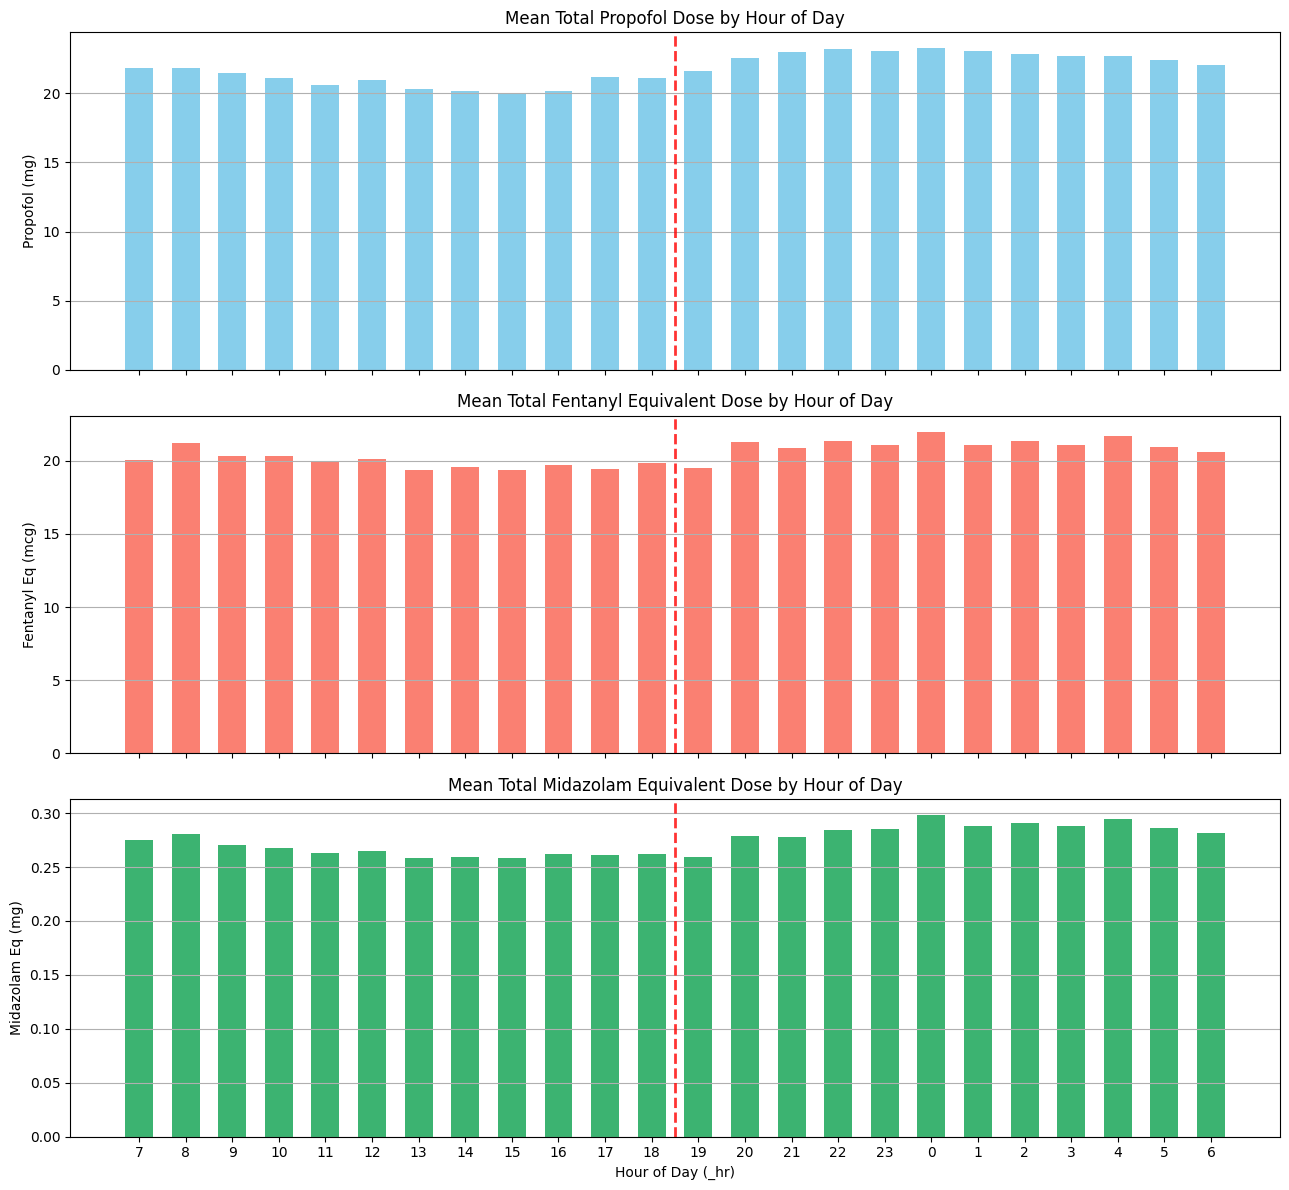

In [163]:
import matplotlib.pyplot as plt
import numpy as np

# Extract variables for plotting
hours = sed_dose_by_hr_of_day['_hr']
propofol = sed_dose_by_hr_of_day['propofol_mg']
fentanyl_eq = sed_dose_by_hr_of_day['_fentanyl_eq_mcg']
midazolam_eq = sed_dose_by_hr_of_day['_midazolam_eq_mg']

# Reorder so that x-axis goes from 7,8,...,23,0,1,...,6
desired_order = list(range(7, 24)) + list(range(0, 7))
hours_ordered = []
propofol_ordered = []
fentanyl_eq_ordered = []
midazolam_eq_ordered = []

for h in desired_order:
    if h in list(hours):
        idx = list(hours).index(h)
        hours_ordered.append(hours.iloc[idx])
        propofol_ordered.append(propofol.iloc[idx])
        fentanyl_eq_ordered.append(fentanyl_eq.iloc[idx])
        midazolam_eq_ordered.append(midazolam_eq.iloc[idx])

hours_ordered = np.array(hours_ordered)
propofol_ordered = np.array(propofol_ordered)
fentanyl_eq_ordered = np.array(fentanyl_eq_ordered)
midazolam_eq_ordered = np.array(midazolam_eq_ordered)

fig, axs = plt.subplots(3, 1, figsize=(13, 12), sharex=True)

x = np.arange(len(hours_ordered))
bar_width = 0.6

# Propofol
axs[0].bar(x, propofol_ordered, color='skyblue', width=bar_width)
axs[0].set_ylabel('Propofol (mg)')
axs[0].set_title('Mean Total Propofol Dose by Hour of Day')
axs[0].grid(True, axis='y')

# Fentanyl Eq
axs[1].bar(x, fentanyl_eq_ordered, color='salmon', width=bar_width)
axs[1].set_ylabel('Fentanyl Eq (mcg)')
axs[1].set_title('Mean Total Fentanyl Equivalent Dose by Hour of Day')
axs[1].grid(True, axis='y')

# Midazolam Eq
axs[2].bar(x, midazolam_eq_ordered, color='mediumseagreen', width=bar_width)
axs[2].set_ylabel('Midazolam Eq (mg)')
axs[2].set_title('Mean Total Midazolam Equivalent Dose by Hour of Day')
axs[2].set_xlabel('Hour of Day (_hr)')
axs[2].grid(True, axis='y')

# Add cutoff lines at _hr=7 and _hr=19 to each axis (find their positions in the reordered hours)
for ax in axs:
    for cutoff in [19]:
        if cutoff in hours_ordered:
            cutoff_pos = np.where(hours_ordered == cutoff)[0][0]
            ax.axvline(cutoff_pos - 0.5, color='red', linestyle='--', linewidth=2, alpha=0.8)
        else:
            insert_pos = np.searchsorted(hours_ordered, cutoff)
            ax.axvline(insert_pos - 0.5, color='red', linestyle='--', linewidth=2, alpha=0.8)

plt.xticks(x, hours_ordered.astype(int))
plt.tight_layout()
plt.show()

## By day shift - for reg

In [ ]:
# q = """
# WITH day_starts AS (
#     FROM sed_dose_by_hr
#     SELECT *
#         , _shift: CASE WHEN _hr >= 7 AND _hr < 19 THEN 'day' ELSE 'night' END
#         , _is_day_start: CASE
#             WHEN _hr = 7 AND COALESCE(LAG(_hr) OVER w, -1) != 7 THEN 1
#             ELSE 0 END
#     WINDOW w AS (PARTITION BY hospitalization_id ORDER BY _dh)       
# )
# FROM day_starts
# -- INNER JOIN cohort_hosp_ids_df USING (hospitalization_id)
# SELECT *
#     , _nth_day: SUM(_is_day_start) OVER w
#     , _day_shift: 'day' || _nth_day::INT::TEXT || '_' || _shift
# WINDOW w AS (PARTITION BY hospitalization_id ORDER BY _dh)       
# ORDER BY hospitalization_id, _dh
# """
# sed_dose_by_hr_w_ids = duckdb.sql(q).df()
# assert len(sed_dose_by_hr_w_ids) == len(cont_sed_dose_by_hr), 'length altered'

In [ ]:
q = """
-- Aggregate per hospitalization, day, shift
FROM sed_dose_by_hr_w_ids
SELECT
    hospitalization_id,
    _nth_day,
    _shift,
    SUM(propofol_mg_total) AS propofol_mg_total,
    SUM(_fentanyl_eq_mcg_total) AS fentanyl_eq_mcg_total,
    SUM(_midazolam_eq_mg_total) AS midazolam_eq_mg_total
GROUP BY hospitalization_id, _nth_day, _shift
"""

sed_dose_agg = duckdb.sql(q).df()

sed_dose_wide = sed_dose_agg.pivot(
    index=['hospitalization_id', '_nth_day'],
    columns='_shift',
    values=['propofol_mg_total', 'fentanyl_eq_mcg_total', 'midazolam_eq_mg_total']
).reset_index()

# Optionally flatten MultiIndex columns and rename as requested
sed_dose_wide.columns = [
    'hospitalization_id', '_nth_day',
    'propofol_day' if ('propofol_mg_total', 'day') in sed_dose_wide.columns else None,
    'propofol_night' if ('propofol_mg_total', 'night') in sed_dose_wide.columns else None,
    'fentanyl_eq_day' if ('fentanyl_eq_mcg_total', 'day') in sed_dose_wide.columns else None,
    'fentanyl_eq_night' if ('fentanyl_eq_mcg_total', 'night') in sed_dose_wide.columns else None,
    'midazolam_eq_day' if ('midazolam_eq_mg_total', 'day') in sed_dose_wide.columns else None,
    'midazolam_eq_night' if ('midazolam_eq_mg_total', 'night') in sed_dose_wide.columns else None,
]
# Remove 'None' columns in case day or night is missing
sed_dose_wide = sed_dose_wide.loc[:, [c for c in sed_dose_wide.columns if c is not None]]

# For full reproducibility, here is a more rigid column assignment to avoid None if both shifts exist:
# sed_dose_wide.columns = [
#     'hospitalization_id', '_nth_day',
#     'propofol_day', 'propofol_night',
#     'fentanyl_eq_day', 'feantanyl_eq_night',
#     'midazolam_eq_day', 'midazolam_eq_night'
# ]

In [ ]:
# q = """
# PIVOT_WIDER sed_dose_by_day_shift
# ON _shift
# USING SUM(propofol_mg_total)
# ORDER BY hospitalization_id, _nth_day
# """
# sed_dose_by_day_shift_w = duckdb.sql(q).df()

# Join

In [47]:
q = """
WITH t3 AS (
    FROM all_timestamps t
    LEFT JOIN mac_w m ON
        t.hospitalization_id = m.hospitalization_id
        AND t.event_dttm = m.admin_dttm
    SELECT t.hospitalization_id, t.event_dttm
        , LAST_VALUE(COLUMNS('_min') IGNORE NULLS) OVER (
            PARTITION BY t.hospitalization_id ORDER BY event_dttm
        )
), t4 AS (
    SELECT hospitalization_id, event_dttm
        , COALESCE(COLUMNS('_min'), 0)
    FROM t3
), t5 AS (
    SELECT *
        -- ref: https://doi.org/10.1016/j.jcrc.2020.11.002
        , _nee: norepinephrine_mcg_kg_min 
            + epinephrine_mcg_kg_min 
            + phenylephrine_mcg_kg_min / 10.0 
            + dopamine_mcg_kg_min / 100.0 
            + vasopressin_u_min * 2.5 
            + angiotensin_mcg_kg_min * 10
        , _hemo_stable_by_nee: CASE WHEN _nee <= 0.2 THEN 1 ELSE 0 END
        -- to cover the two vasos not in the formula: milrinone and dobutamine
        , _hemo_stable_by_abc: CASE WHEN dobutamine_mcg_kg_min < 0.5
            AND milrinone_mcg_kg_min = 0 THEN 1 ELSE 0 END
        , _hemo_stable: CASE WHEN _hemo_stable_by_nee AND _hemo_stable_by_abc THEN 1 ELSE 0 END
    FROM t4
)
SELECT *
FROM t5
ORDER BY hospitalization_id, event_dttm
"""
# a = augmented
mac_wa = duckdb.sql(q).df()

In [ ]:
q = """
WITH t1 AS (
FROM timestamps_w_ids t
LEFT JOIN sbt_outcomes_f r ON
    t.hospitalization_id = r.hospitalization_id
    AND t.event_dttm = r.recorded_dttm
LEFT JOIN vitals_w v ON
    t.hospitalization_id = v.hospitalization_id
    AND t.event_dttm = v.recorded_dttm
    AND v.spo2 IS NOT NULL
LEFT JOIN mac_wa m ON
    t.hospitalization_id = m.hospitalization_id
    AND t.event_dttm = m.event_dttm
LEFT JOIN pa_w p ON
    t.hospitalization_id = p.hospitalization_id
    AND t.event_dttm = p.recorded_dttm
SELECT _hospitalization_id: t.hospitalization_id
    , _time: t.event_dttm
    , _nth_day
    , _day_shift_id
    --, _nth_hr: ROW_NUMBER() OVER (PARTITION BY _hospitalization_id ORDER BY _time)
    , device_name, device_category
    , mode_name, mode_category
    , fio2_set
    , peep_set
    , pressure_support_set
    , tracheostomy
    , gcs_total
    , spo2
    , _spo2: LAST_VALUE(v.spo2 IGNORE NULLS) OVER (PARTITION BY _hospitalization_id ORDER BY _time)
    , _resp_stable: CASE
        WHEN fio2_set <= 0.5
            AND peep_set <= 8
            AND _spo2 >= 88
        THEN 1 ELSE 0 END
    , m.* 
    , _stable: CASE WHEN _resp_stable AND _hemo_stable THEN 1 ELSE 0 END
    , sbt_eligible: CASE WHEN device_category = 'imv' AND _stable = 1 AND tracheostomy = 0 
        THEN 1 ELSE 0 END
    , sbt_done
    , extub
)
SELECT *
FROM t1
ORDER BY _hospitalization_id, _time
"""
full_view = duckdb.sql(q).df()

BinderException: Binder Error: Referenced column "extub" not found in FROM clause!
Candidate bindings: "_extub_1st", "_intub", "_death_after_extub_wo_reintub", "_hemo_stable", "_hemo_stable_by_abc"

In [ ]:
q = """
SELECT _hospitalization_id
    , _time
    , sbt_eligible
    , sbt_done
    , extub
    , device_category, device_name
    , mode_category, mode_name
    , fio2_set
    , peep_set
    , pressure_support_set
    , _spo2
FROM full_view
--WHERE hospitalization_id in ('20001361', '20004088', '20005024')
"""
check_view = duckdb.sql(q).df()

q = """
SELECT _hospitalization_id
    , _nth_day
    , sbt_eligible: COALESCE(MAX(sbt_eligible), 0)
    , sbt_done: COALESCE(MAX(sbt_done), 0)
    , extub: COALESCE(MAX(extub), 0)
FROM full_view
--WHERE hospitalization_id in ('20001361', '20004088', '20005024')
GROUP BY _hospitalization_id, _nth_day
ORDER BY _hospitalization_id, _nth_day
"""
agg_view = duckdb.sql(q).df()

# Analytical dataset

In [265]:
q = """
FROM resp_traj_by_days
SELECT *
    , _exit_cumsum: SUM(_exit) OVER w
    -- first exit row
    , _exit_1st: CASE WHEN _exit_cumsum = 1 AND _exit = 1 THEN 1 ELSE 0 END
    , _intub_cumsum: SUM(_intub) OVER w
    , _intub_1st: CASE WHEN _intub_cumsum = 1 AND _intub = 1 THEN 1 ELSE 0 END
WINDOW w AS (PARTITION BY hospitalization_id ORDER BY _nth_day)
QUALIFY (_exit_cumsum < 1 OR _exit_1st = 1)
    AND _intub_cumsum > 0
    -- AND _nth_day >= 1
ORDER BY hospitalization_id, _nth_day
"""
outcomes = duckdb.sql(q).df()

In [266]:
q = """
FROM outcomes o
LEFT JOIN sed_dose_wide s
    ON o.hospitalization_id = s.hospitalization_id
    AND o._nth_day = s._nth_day
SELECT o.hospitalization_id
    , o._nth_day
    , o.sbt_done
    , o.success_extub
    , _propofol_day: COALESCE(s.propofol_day, 0)
    , _propofol_night: COALESCE(s.propofol_night, 0)
    , _fentanyl_eq_day: COALESCE(s.fentanyl_eq_day, 0)
    , _fentanyl_eq_night: COALESCE(s.fentanyl_eq_night, 0)
    , _midazolam_eq_day: COALESCE(s.midazolam_eq_day, 0)
    , _midazolam_eq_night: COALESCE(s.midazolam_eq_night, 0)
    , propofol_diff: _propofol_night - _propofol_day
    , fentanyl_eq_diff: _fentanyl_eq_night - _fentanyl_eq_day
    , midazolam_eq_diff: _midazolam_eq_night - _midazolam_eq_day
ORDER BY o.hospitalization_id, o._nth_day
"""
joined = duckdb.sql(q).df()